In [1]:
import os
import datetime
import math
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
    
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
# DATA
df1 = pd.read_csv('data_day.csv')
df2 = pd.read_csv('data_2018-08-05_2021-04-30.csv')
df3 = pd.read_csv('data_2018-05-05_2018-08-04.csv')
df4 = pd.read_csv('data_2015-08-09_2018-05-04.csv')
df5 = pd.read_csv('data_2013-02-12_2015-08-08.csv')
df6 = pd.read_csv('data_2010-05-19_to_2013-02-11.csv')
df7 = pd.read_csv('data_2007-08-23_to_2010-05-18.csv')
df8 = pd.read_csv('data_2004-11-26_to_2007-08-22.csv')
df = pd.concat([df6, df5, df4, df3, df2, df1])
df.index = range(0,4996)
df.tail()

date_time = pd.concat([pd.to_datetime(df['datetime'][0:4000]),pd.to_datetime(df['datetime'][4000:])])
data_use = df[['temp','tempmax', 'tempmin','humidity', 'precip', 'windspeed', 'solarradiation', 'solarenergy']]
print(data_use)

      temp  tempmax  tempmin  humidity  precip  windspeed  solarradiation  \
0     30.8     36.5     26.0      78.1   0.000       20.5           301.4   
1     31.3     36.4     27.0      76.0   0.300       24.1           281.5   
2     30.7     39.0     26.0      76.1   2.300       40.7           237.1   
3     31.5     39.6     26.0      71.2   0.800       15.1           296.8   
4     27.6     30.8     25.8      80.1  33.000       22.7           240.8   
...    ...      ...      ...       ...     ...        ...             ...   
4991  20.5     22.0     19.5      93.8   8.794       17.5           148.7   
4992  22.4     26.5     20.0      84.5   0.683       19.4           140.8   
4993  22.6     26.6     20.0      85.5   0.072       20.3           131.9   
4994  23.0     26.0     19.0      82.4   3.300       20.5            63.7   
4995  16.0     18.0     14.0      91.4   3.400       22.3            15.8   

      solarenergy  
0            26.1  
1            24.3  
2            20

In [3]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
timestamp_s[1] - timestamp_s[0]

86400.0

C:\Users\tridu\AppData\Local\Temp\ipykernel_8572\1206436225.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_use['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
C:\Users\tridu\AppData\Local\Temp\ipykernel_8572\1206436225.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_use['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))


Index(['temp', 'tempmax', 'tempmin', 'humidity', 'precip', 'windspeed',
       'solarradiation', 'solarenergy', 'Year sin', 'Year cos'],
      dtype='object')

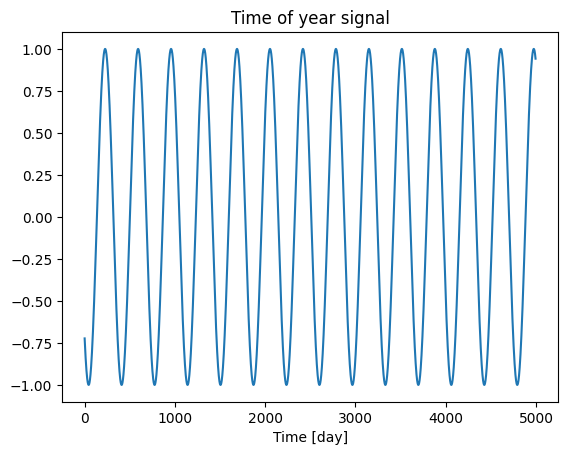

In [4]:
# PERIOD TIME

day = 24*60*60
year = (365.2425)*day
# df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
# df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
data_use['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
data_use['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

# plt.plot(np.array(df['Year sin'])[:366])
plt.plot(np.array(data_use['Year cos'])[:])
plt.xlabel('Time [day]')
plt.title('Time of year signal')
data_use.columns

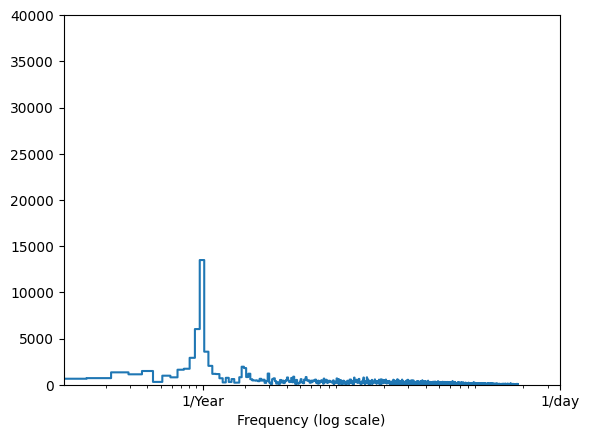

In [5]:
fft = tf.signal.rfft(data_use['temp'])
f_per_dataset = np.arange(0, len(fft))

n_samples_day = len(data_use['humidity'])
days_per_year = 365.2524
years_per_dataset = n_samples_day/(days_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 40000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [6]:
number_train = int(data_use.shape[0] * 0.8)
train, test = data_use[0:number_train], data_use[number_train:]

In [7]:
def create_data(in_steps, out_steps, data, feature):
    X = []
    y = []
    for i in range(len(data)-in_steps-out_steps):
        X.append(data[i:i+in_steps])
        y.append(data[i+in_steps:i+in_steps+out_steps][feature])
    return np.array(X), np.array(y)
def normalize(data, train_mean, train_std):
    data_norm = (data - train_mean)/train_std
    return data_norm
def unnormalize(data, train_mean, train_std):
    data_unnorm = (data * train_std) + train_mean
    return data_unnorm


In [8]:
in_steps = 365
out_steps = 14

In [9]:
X_train, y_train = create_data(in_steps, out_steps, train, ['temp','humidity'])
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 2)

X_test, y_test = create_data(in_steps, out_steps, test, ['temp','humidity'])
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 2)

X_train_norm = normalize(X_train, X_train.mean(), X_train.std())
y_train_norm = normalize(y_train, y_train.mean(), y_train.std())

X_test_norm = normalize(X_test, X_train.mean(), X_train.std())
y_test_norm = normalize(y_test, y_train.mean(), y_train.std())

print(X_train_norm.shape, y_train_norm.shape, X_test_norm.shape, y_test_norm.shape)


(3617, 365, 10) (3617, 14, 2) (621, 365, 10) (621, 14, 2)


In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(out_steps*2),
    tf.keras.layers.Reshape([out_steps, 2])
])



In [19]:
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Lion(learning_rate = 0.001),
)

In [20]:
history = model.fit(X_train_norm, y_train_norm, epochs=50, validation_split=0.2, batch_size=32, validation_batch_size=32)

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - loss: 0.2364 - val_loss: 0.1019
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 16s 177ms/step - loss: 0.0790 - val_loss: 0.0914
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 16s 176ms/step - loss: 0.0735 - val_loss: 0.0850
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 16s 178ms/step - loss: 0.0678 - val_loss: 0.0807
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 16s 176ms/step - loss: 0.0666 - val_loss: 0.0769
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 16s 177ms/step - loss: 0.0642 - val_loss: 0.0754
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 16s 175ms/step - loss: 0.0628 - val_loss: 0.0738
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 16s 178ms/step - loss: 0.0625 - val_loss: 0.0800
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 16s 177ms/step - loss: 0.0636 - val_loss: 0.0708
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 187ms/step - loss: 0.0613 - val_loss: 0.0702
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 19s 213ms/step - loss: 0.0615 - val_loss: 0.0697
Epoch 12/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 20

In [26]:
model.save('lstm365-not_overfit.keras')

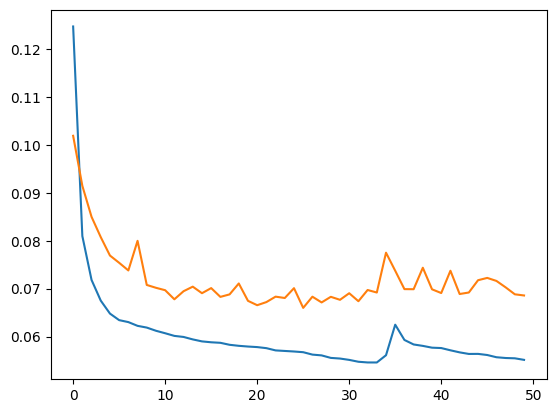

In [21]:
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])

In [22]:
model.evaluate(X_test_norm, y_test_norm)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0963


0.1248328909277916

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step
Day:  1
MAE:  1.3080993492630175
MSE:  2.972747228172361
CORR:  0.9341400642978589
Day:  2
MAE:  1.8241538626752232
MSE:  5.663993207596516
CORR:  0.876116698300402
Day:  3
MAE:  2.1815512204131835
MSE:  8.165607586078185
CORR:  0.8289754368798011
Day:  4
MAE:  2.353725645277235
MSE:  9.427912735589139
CORR:  0.8047434150671604
Day:  5
MAE:  2.4011592398135173
MSE:  9.879272014151002
CORR:  0.7968868115228207
Day:  6
MAE:  2.4676628598076515
MSE:  10.660120790843425
CORR:  0.785041455207463
Day:  7
MAE:  2.454146007101701
MSE:  10.653950452871769
CORR:  0.7836036085007907
Day:  8
MAE:  2.4429851685553166
MSE:  10.425036626442315
CORR:  0.7737262850832322
Day:  9
MAE:  2.543927398779926
MSE:  11.26900077874893
CORR:  0.7679529537738318
Day:  10
MAE:  2.573574163218819
MSE:  11.457919355658985
CORR:  0.7661432593447962
Day:  11
MAE:  2.6027415971249197
MSE:  11.328417298960302
CORR:  0.759149628218808
Day:  12
MAE:  2.6944795679163045
MSE:  12.2577

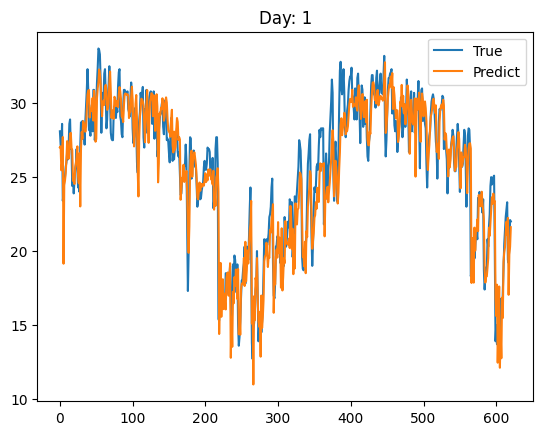

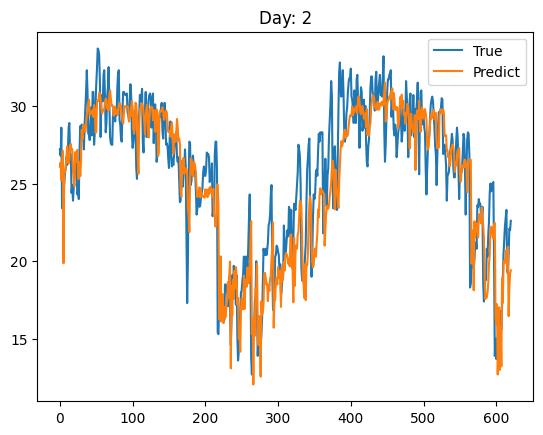

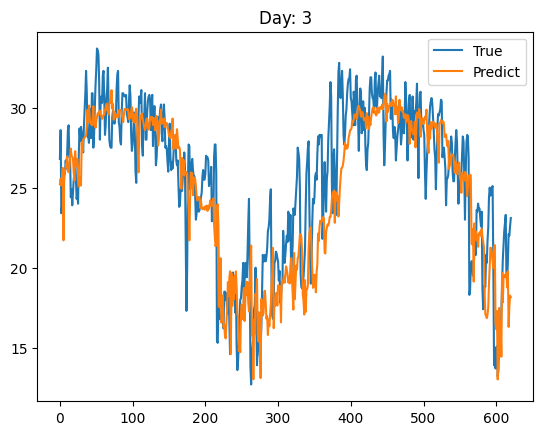

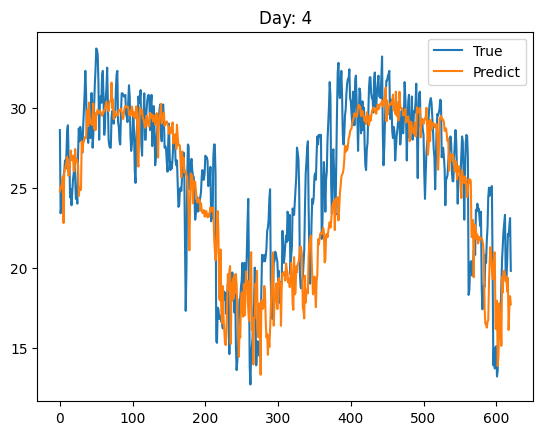

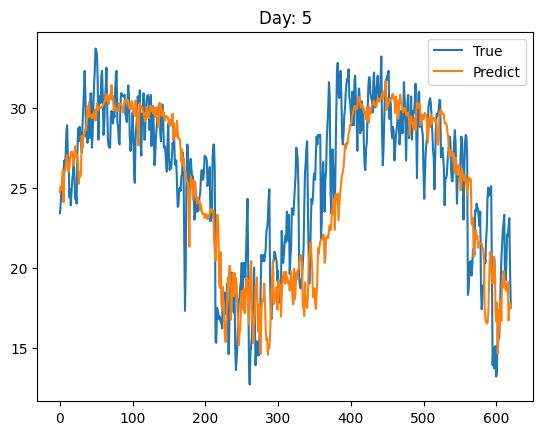

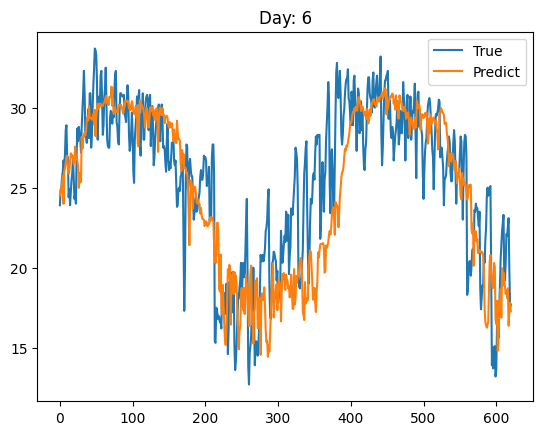

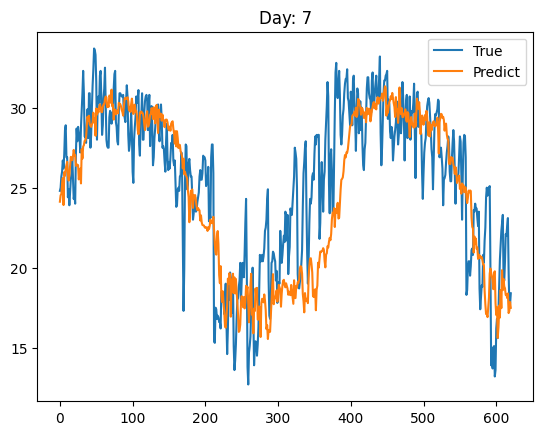

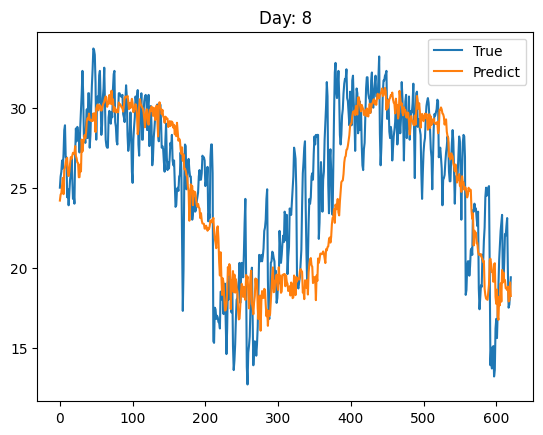

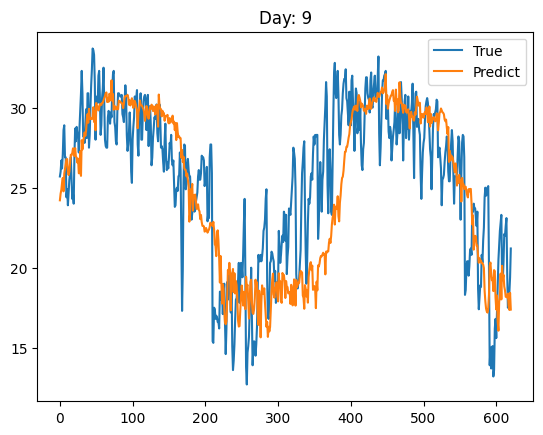

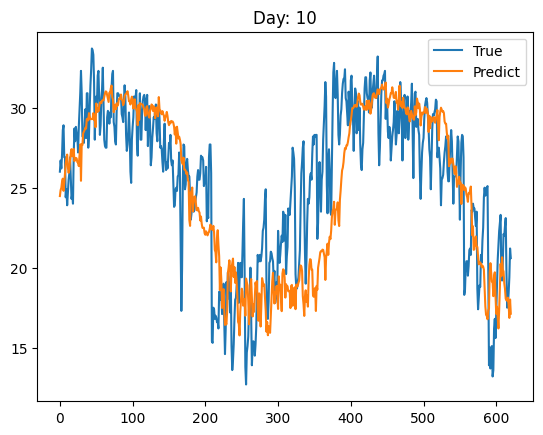

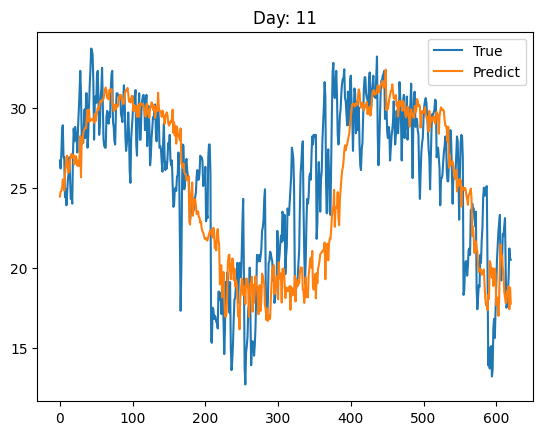

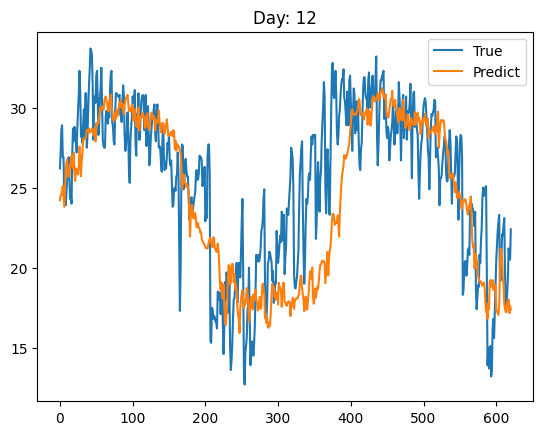

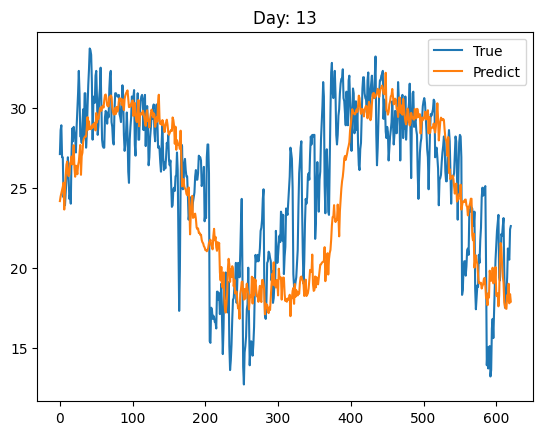

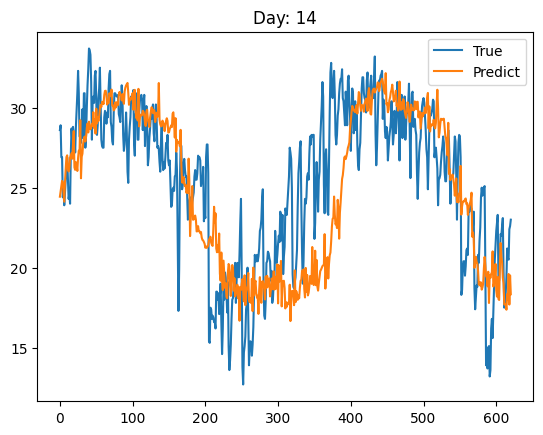

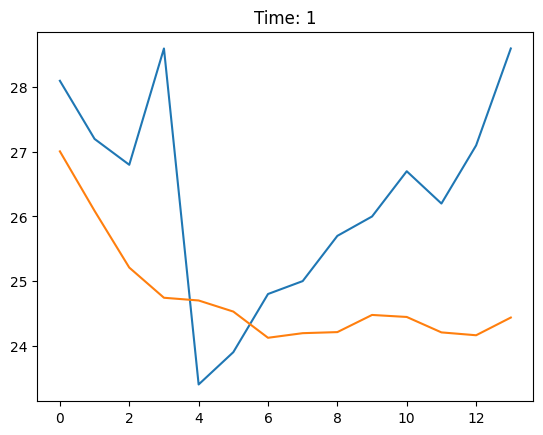

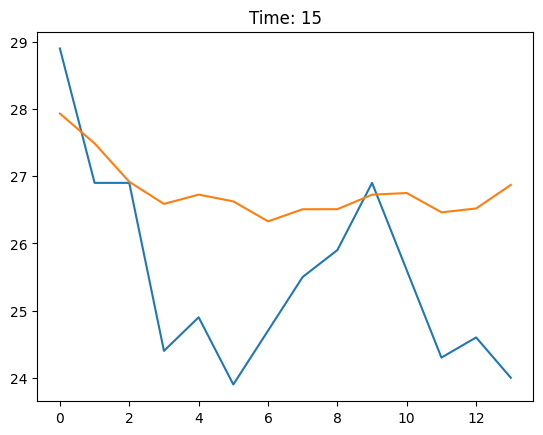

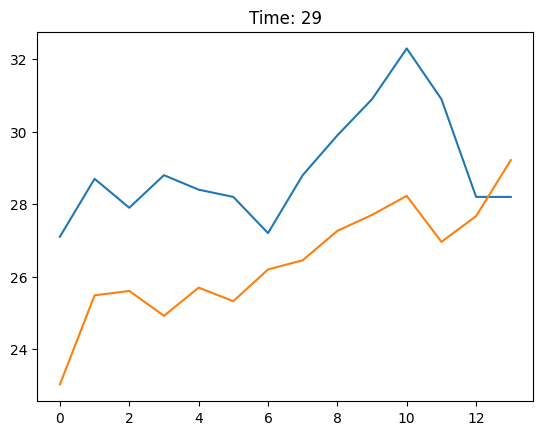

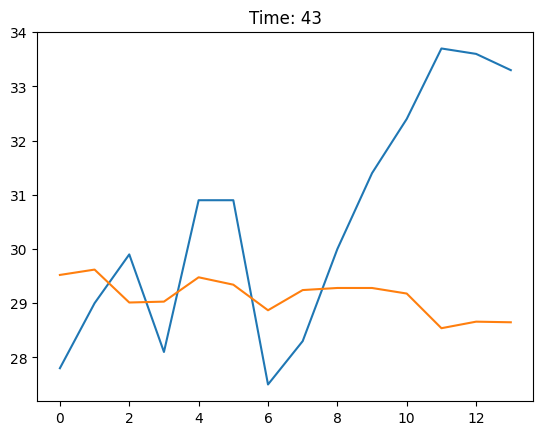

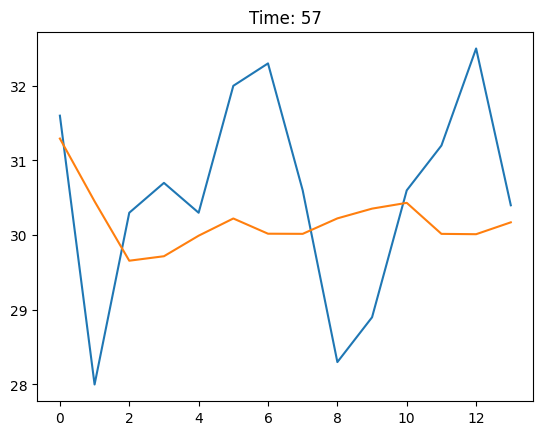

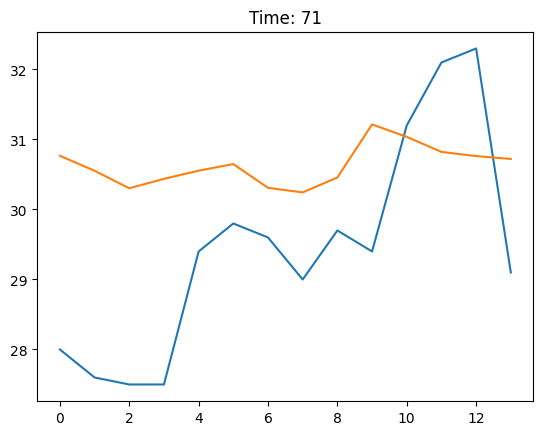

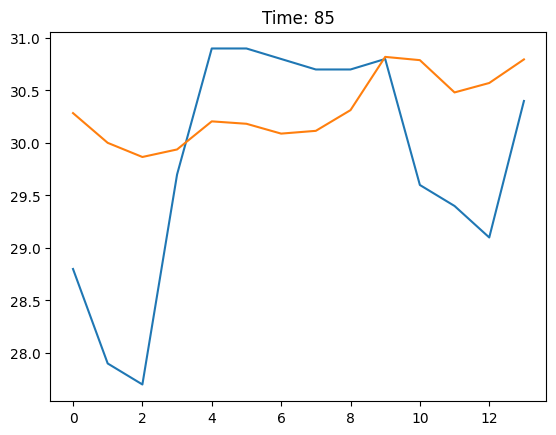

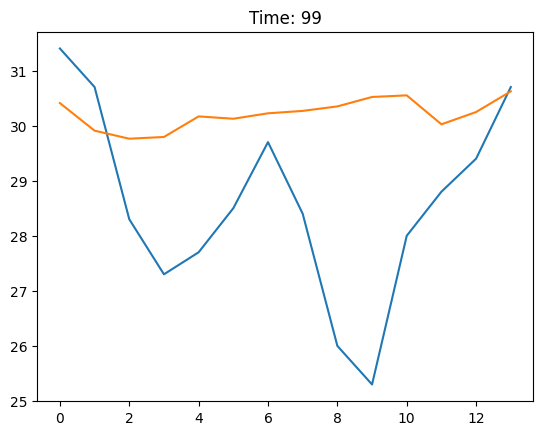

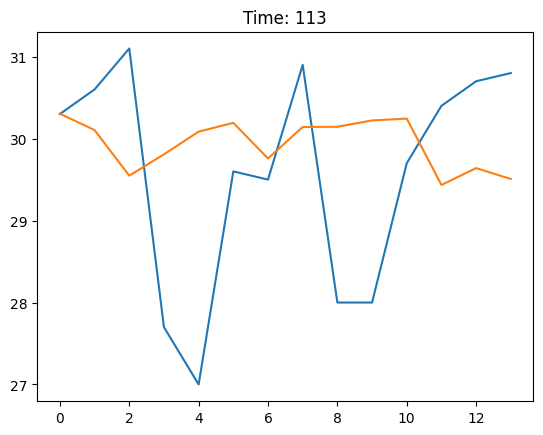

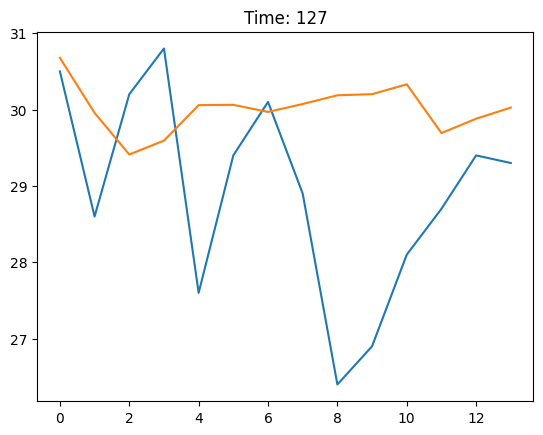

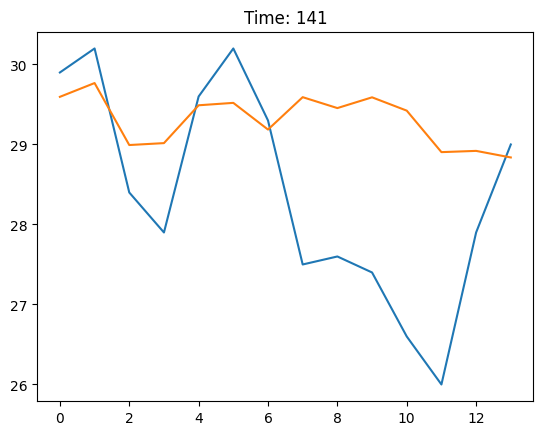

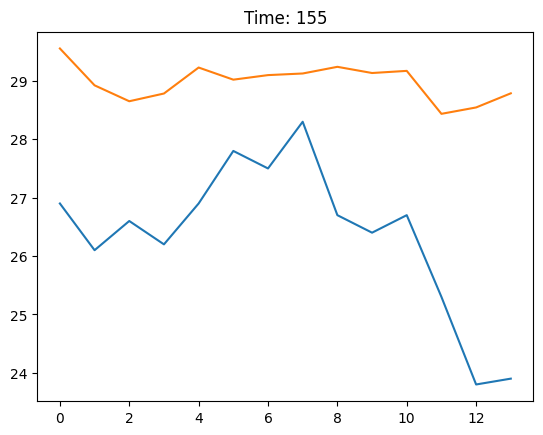

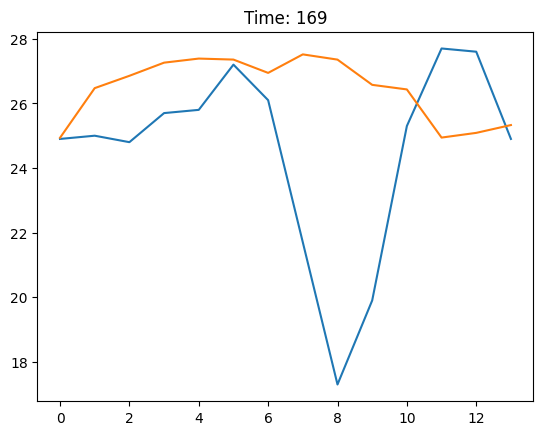

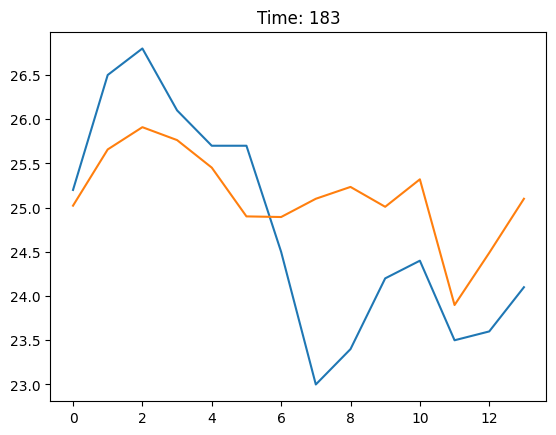

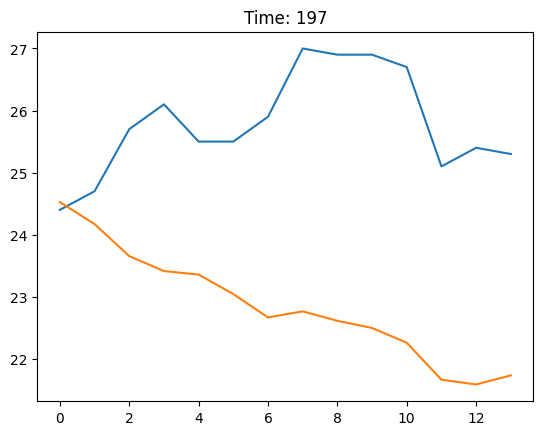

In [24]:
predict = model.predict(X_test_norm)
predict_unnorm = unnormalize(predict, y_train.mean(), y_train.std())
y_test_unnorm = unnormalize(y_test_norm, y_train.mean(), y_train.std())
plt.legend(['Predict', 'True'])
for i in range(14):
    print('Day: ', i+1)
    print('MAE: ', mean_absolute_error(y_test_unnorm[:,i,0], predict_unnorm[:,i,0]))
    print('MSE: ', mean_squared_error(y_test_unnorm[:,i,0], predict_unnorm[:,i,0]))
    print('CORR: ', np.corrcoef(y_test_unnorm[:,i,0], predict_unnorm[:,i,0])[0,1])
for i in range(14):
    plt.title('Day: ' + str(i+1))
    plt.plot(y_test_unnorm[:,i,0])
    plt.plot(predict_unnorm[:,i,0])
    plt.legend(['True', 'Predict'])
    plt.show()
for i in range(0, 200, 14):
    plt.title('Time: ' + str(i+1))
    plt.plot(y_test_unnorm[i,:,0])
    plt.plot(predict_unnorm[i,:,0])
    plt.show()